<a href="https://colab.research.google.com/github/SLPcourse/CSC3160-120090195-ChengYang/blob/main/RoBERTa_Attribution_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json

In [2]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 9.4 MB/s eta 0:00:00


In [ ]:
import json

import torch
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (
    RobertaForSequenceClassification,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
)

from google.colab import drive
drive.mount('/content/drive')

# Definition of a custom dataset for the sequence classification task
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels, tokenizer, max_length=512):
        self.inputs = inputs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    # Return the number of examples in the dataset
    def __len__(self):
        return len(self.inputs)

    # Return a single example and its corresponding label
    def __getitem__(self, index):
        input_ids = self.tokenizer.encode(
            self.inputs[index], add_special_tokens=True, max_length=self.max_length
        )
        label = self.labels[index]
        return input_ids, label


# Definition of a model trainer for the sequence classification task
class ModelTrainer:
    def __init__(
        self,
        train_file,
        val_file,
        test_file,
        model_name="roberta-base",
        batch_size=8,
        num_epochs=1,
        learning_rate=2e-5,
        warmup_steps=0.1,
    ):
        # Load the training, validation, and test data from JSON files
        self.train_data = self.load_data(train_file)
        self.val_data = self.load_data(val_file)
        self.test_data = self.load_data(test_file)
        # Instantiate a tokenizer and a pre-trained model for sequence classification
        self.tokenizer = RobertaTokenizer.from_pretrained(model_name)
        self.model = RobertaForSequenceClassification.from_pretrained(model_name).cuda()
        # Set the batch size, number of epochs, loss function, optimizer, and learning rate scheduler
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate)
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=int(warmup_steps * len(self.train_data) / self.batch_size),
            num_training_steps=len(self.train_data)
            * self.num_epochs
            // self.batch_size,
        )

    # Load data from a JSON file and return a list of examples
    def load_data(self, filepath):
        with open(filepath, "r") as f:
            data = json.load(f)
        examples = []
        for example in data:
            text = example["text"]
            label = example["fake"]
            examples.append({"text": text, "label": label})
        return examples

    # Tokenize the inputs and labels and return them as two lists
    def tokenize_inputs(self, data):
        inputs = []
        labels = []
        for example in data:
            input_ids = self.tokenizer.encode(
                example["text"],
                add_special_tokens=True,
                truncation=True,
                max_length=512,
            )
            inputs.append(input_ids)
            labels.append(example["label"])
        return inputs, labels

    # Function to pad input sequences and return them in a batch
    def collate_fn(self, batch):
        input_ids = [item[0] for item in batch]
        labels = [item[1] for item in batch]
        # Get the maximum length of the input sequences in the batch
        max_length = max(len(ids) for ids in input_ids)
        input_ids_padded = []
        attention_masks = []
        # Pad the input sequences and create attention masks
        for ids in input_ids:
            padding = [0] * (max_length - len(ids))
            input_ids_padded.append(ids + padding)
            attention_masks.append([1] * len(ids) + padding)
        # Return the inputs and labels as a dictionary and a tensor, respectively
        inputs = {
            "input_ids": torch.tensor(input_ids_padded),
            "attention_mask": torch.tensor(attention_masks),
        }
        return inputs, torch.tensor(labels)

    # Train the model on a given dataloader
    def train_model(self, train_loader):
        # Set the model to training mode and initialize the total loss
        self.model.train()
        total_loss = 0.0
        pbar = tqdm(total=len(train_loader))
        # Iterate over the batches in the dataloader
        for step, (inputs, labels) in enumerate(train_loader, start=1):
            # Clear the gradients, get the model outputs, and calculate the loss
            self.optimizer.zero_grad()
            outputs = self.model(
                inputs["input_ids"].cuda(),
                attention_mask=inputs["attention_mask"].cuda(),
            )
            loss = self.criterion(outputs.logits, labels.cuda())
            # Backpropagate the loss, update the parameters, and adjust the learning rate
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            # Update the total loss and calculate the average loss
            total_loss += loss.item()
            avg_loss = total_loss / step
            # Update the progress bar
            pbar.set_description(f"avg_loss: {avg_loss:.4f}")
            pbar.update(1)
        pbar.close()
        # Return the average loss over the entire dataset
        return total_loss / len(train_loader)

    # Evaluate the model on a given dataloader
    def evaluate_model(self, test_loader):
        # Set the model to evaluation mode and initialize the true and predicted labels
        self.model.eval()
        true_labels = []
        predicted_labels = []
        with torch.no_grad():
            # Iterate over the batches in the dataloader and get the model outputs
            for inputs, labels in test_loader:
                outputs = self.model(
                    inputs["input_ids"].cuda(),
                    attention_mask=inputs["attention_mask"].cuda(),
                )
                # Append the true and predicted labels to their respective lists
                true_labels.extend(labels)
                predicted_labels.extend(torch.argmax(outputs.logits, dim=1).cpu())
        # Calculate the classification report and the accuracy of the model
        report = classification_report(true_labels, predicted_labels, digits=4)
        return (
            report,
            torch.sum(torch.tensor(true_labels) == torch.tensor(predicted_labels))
            / len(true_labels),
        )

    # Train and evaluate the model for a given number of epochs
    def run_training(self):
        # Tokenize the inputs and labels for the training, validation, and test datasets
        train_inputs, train_labels = self.tokenize_inputs(self.train_data)
        val_inputs, val_labels = self.tokenize_inputs(self.val_data)
        test_inputs, test_labels = self.tokenize_inputs(self.test_data)

        # Create dataloaders for the training, validation, and test datasets
        train_dataset = CustomDataset(train_inputs, train_labels, self.tokenizer)
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=self.collate_fn,
        )
        val_dataset = CustomDataset(val_inputs, val_labels, self.tokenizer)
        val_loader = DataLoader(
            val_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn
        )
        test_dataset = CustomDataset(test_inputs, test_labels, self.tokenizer)
        test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn
        )

        # Train the model for a given number of epochs and save the best model based on the validation accuracy
        best_accuracy = 0
        for epoch in range(self.num_epochs):
            train_loss = self.train_model(train_loader)
            val_report, val_accuracy = self.evaluate_model(val_loader)
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                torch.save(self.model.state_dict(), "best_model.pt")
            # Print the epoch number, training loss, and validation accuracy
            print(
                f"Epoch {epoch + 1}, train loss: {train_loss:.4f}, val accuracy: {val_accuracy:.4f}"
            )
            # Print the classification report for the validation dataset
            print(val_report)
        # Load the best model based on the validation accuracy and evaluate it on the test dataset
        self.model.load_state_dict(torch.load("best_model.pt"))
        test_report, test_accuracy = self.evaluate_model(test_loader)
        # Print the best accuracy and the classification report for the test dataset
        print(f"Best accuracy: {test_accuracy:.4f}")
        print(test_report)


if __name__ == "__main__":
    trainer = ModelTrainer(
        "/content/drive/MyDrive/train.json", "/content/drive/MyDrive/val.json", "/content/drive/MyDrive/test.json"
    )
    trainer.run_training()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Streaming output truncated to the last 5000 lines.
avg_loss: 0.0252: 100%|██████████| 7691/7691 [19:22<00:00,  6.62it/s]


Epoch 1, train loss: 0.0252, val accuracy: 0.9985
              precision    recall  f1-score   support

           0     0.9998    0.9981    0.9989      4654
           1     0.9959    0.9995    0.9977      2182

    accuracy                         0.9985      6836
   macro avg     0.9978    0.9988    0.9983      6836
weighted avg     0.9985    0.9985    0.9985      6836

Best accuracy: 0.9975
              precision    recall  f1-score   support

           0     0.9997    0.9967    0.9982     11720
           1     0.9928    0.9994    0.9961      5370

    accuracy                         0.9975     17090
   macro avg     0.9963    0.9981    0.9972     17090
weighted avg     0.9976    0.9975    0.9975     17090



In [3]:
# Import required libraries
import numpy as np
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizer



def load_model(model_path):
    # Load the tokenizer and model from the "roberta-base" pre-trained model
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    model = RobertaForSequenceClassification.from_pretrained("roberta-base").cuda()

    # Load the saved state dict of the fine-tuned model
    model.load_state_dict(torch.load(model_path))

    return tokenizer, model


def preprocess_text(tokenizer, input_text, max_length):
    # Tokenize the input text using the tokenizer
    inputs = tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        return_tensors="pt",
        max_length=max_length,
        truncation=True,
    )

    # Get the input_ids and attention_mask tensors
    return inputs["input_ids"].cuda(), inputs["attention_mask"].cuda()


def get_prediction(model, input_ids, attention_mask):
    # Get the predicted label using the input_ids and attention_mask
    outputs = model(input_ids, attention_mask=attention_mask)
    predicted_label = np.argmax(outputs.logits.detach().cpu().numpy())
    return predicted_label


def main():
    # Load the fine-tuned model from the saved state dict
    model_path = "/content/drive/MyDrive/best_model.pt"
    tokenizer, model = load_model(model_path)

    # Get the test sentence from the file
    with open("/content/drive/MyDrive/text_test.txt", encoding="utf-8", mode="r") as fr:
        lines = fr.readlines()
        for line in lines:
            test_sentence = line.strip()
            # Preprocess the test sentence and get the predicted label
            input_ids, attention_mask = preprocess_text(
                tokenizer, test_sentence, max_length=512
            )
            predicted_label = get_prediction(model, input_ids, attention_mask)

            # Print the output based on the predicted label
            if predicted_label == 0:
                print("human")
            else:
                print("chatGPT")


if __name__ == "__main__":
    main()


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

chatGPT
chatGPT
human


In [4]:
pip install transformers-interpret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.6 MB/s eta 0:00:00


In [5]:
from transformers import pipeline
from transformers_interpret import SequenceClassificationExplainer
model_path = "/content/drive/MyDrive/best_model.pt"
tokenizer, model = load_model(model_path)
text = 'Deodorant is used to help reduce body odor, which is the smell that can come from sweating. When we sweat, bacteria on our skin can break down the sweat and produce a smell. Deodorant contains antimicrobial agents that can kill the bacteria and help reduce body odor. It also often contains fragrances that can help cover up any remaining smell.\n\nWhile it is true that some animals use their natural smells to attract a mate, humans do not typically rely on body odor as a way of attracting a partner. In fact, body odor can be considered unpleasant by some people. Using deodorant can help us feel more clean and fresh, and can help us feel more confident in social situations.'

explainer = SequenceClassificationExplainer(model, tokenizer)


# Explain the classification
explanation = explainer(text)

# Print the explanation

print(explanation)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

[('<s>', 0.0), ('De', 0.017690257411076556), ('odor', -0.014085578570074787), ('ant', -0.016258016571996967), ('is', 0.0024786750189398684), ('used', -0.05115312551540889), ('to', -0.018976256256135693), ('help', 0.007296505099770662), ('reduce', 0.016084152100335654), ('body', 0.06495655433427262), ('odor', 0.017428492370088054), (',', 0.12071386613658), ('which', 0.046139013543983), ('is', 0.006963057049809147), ('the', 0.06166217461451146), ('smell', 0.05064662471540402), ('that', 0.09819788900554303), ('can', 0.03746951277025786), ('come', 0.014074473819921766), ('from', 0.012984117036534347), ('sweating', 0.0019418717270552896), ('.', 0.2691310893111506), ('When', -0.031815329024919306), ('we', 0.029972386577453804), ('sweat', -0.010024619276098044), (',', 0.2390655363798844), ('bacteria', -0.010496479481746743), ('on', -0.03000438703878979), ('our', 0.04985719409546233), ('skin', 0.06887146060881841), ('can', 0.06328353987843613), ('break', 0.02190581890171681), ('down', 0.040750

In [ ]:
explainer.visualize()

# **Calculate the sentiment score for word level and sentence level.**

In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import transformers
# This is for sentence level
import shap

# load a transformers pipeline model
model = transformers.pipeline('sentiment-analysis', return_all_scores=True)

# explain the model on two sample inputs
model(['Deodorant is used to help reduce body odor, which is the smell that can come from sweating. When we sweat, bacteria on our skin can break down the sweat and produce a smell. Deodorant contains antimicrobial agents that can kill the bacteria and help reduce body odor. It also often contains fragrances that can help cover up any remaining smell.\n\nWhile it is true that some animals use their natural smells to attract a mate, humans do not typically rely on body odor as a way of attracting a partner. In fact, body odor can be considered unpleasant by some people. Using deodorant can help us feel more clean and fresh, and can help us feel more confident in social situations.'])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


`return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.


[[{'label': 'NEGATIVE', 'score': 0.3546455502510071},
  {'label': 'POSITIVE', 'score': 0.6453544497489929}]]

In [6]:
pip install afinn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53448 sha256=59aa4d8932b4247a20ce0c5a718b00aefc0e241b6a0a7c296a37ce23d0826acf
  Stored in directory: /root/.cache/pip/wheels/79/91/ee/8374d9bc8c6c0896a2db75afdfd63d43653902407a0e76cd94
Successfully built afinn


In [7]:
from afinn import Afinn
afinn = Afinn()
# Calculate sentiment score for a single string
text = 'amazing'
score = afinn.score(text)/5
print(score)  # Output: 3.0

0.8


# **Get the part of speech for a single word**

In [8]:
pip install nltk


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import nltk
nltk.download('universal_tagset')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd

data = pos_tag(word_tokenize("John's big idea isn't all that bad."), tagset='universal')
df = pd.DataFrame.from_records(
    data, columns=['Word', 'Part of Speech'])
df
  

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,Word,Part of Speech
0,John,NOUN
1,'s,PRT
2,big,ADJ
3,idea,NOUN
4,is,VERB
5,n't,ADV
6,all,DET
7,that,DET
8,bad,ADJ
9,.,.


In [ ]:
df['Sentiment'] = df['Word'].apply(afinn.score)/5

In [ ]:
df

,Word,Part of Speech,Sentiment
0,John,NOUN,0.0
1,'s,PRT,0.0
2,big,ADJ,0.2
3,idea,NOUN,0.0
4,is,VERB,0.0
5,n't,ADV,0.0
6,all,DET,0.0
7,that,DET,0.0
8,bad,ADJ,-0.6
9,.,.,0.0


# **Word level analysis**

In [10]:
def load_data_GPT(filepath):
    with open(filepath, "r") as f:
        data = json.load(f)
    examples = []
    for example in data:
        text = example["text"]
        label = example["fake"]
        if int(label) == 1: 
          examples.append(text)
    return examples

In [11]:
GPT_text = load_data_GPT('/content/drive/MyDrive/test.json')[:20]

In [13]:
import pandas as pd
import numpy as np
from transformers import pipeline
from transformers_interpret import SequenceClassificationExplainer
from afinn import Afinn
afinn = Afinn()
model_path = "/content/drive/MyDrive/best_model.pt"
tokenizer, model = load_model(model_path)
explainer = SequenceClassificationExplainer(model, tokenizer)
df_attribution = pd.DataFrame()

for text in GPT_text:
    test_sentence = text.strip()
    print(test_sentence)
    explanation = explainer(test_sentence)
    temp = pd.DataFrame.from_records(explanation, columns=['Word', 'Attribution Score'])
    df_attribution = pd.concat([df_attribution,temp])

df_attribution['Sentiment'] = df_attribution['Word'].apply(afinn.score)/5

df_PartOfSpeech = pd.DataFrame()


for text in GPT_text:
    test_sentence = text.strip()
    data = pos_tag(word_tokenize(test_sentence), tagset='universal')
    temp = pd.DataFrame.from_records(data, columns=['Word', 'Part of Speech'])
    df_PartOfSpeech = pd.concat([df_PartOfSpeech,temp])




Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

Deodorant is used to help reduce body odor, which is the smell that can come from sweating. When we sweat, bacteria on our skin can break down the sweat and produce a smell. Deodorant contains antimicrobial agents that can kill the bacteria and help reduce body odor. It also often contains fragrances that can help cover up any remaining smell.

While it is true that some animals use their natural smells to attract a mate, humans do not typically rely on body odor as a way of attracting a partner. In fact, body odor can be considered unpleasant by some people. Using deodorant can help us feel more clean and fresh, and can help us feel more confident in social situations.
A surname is a family name passed down from one generation to another, while a given name is a personal name given to an individual at birth or at a young age. The given name is also sometimes referred to as a first name or a forename.\n\nIn many cultures, the surname is the last name and is used to identify a person wi

In [14]:
df_attribution

,Word,Attribution Score,Sentiment
0,<s>,0.000000,0.0
1,De,0.017690,0.0
2,odor,-0.014086,0.0
3,ant,-0.016258,0.0
4,is,0.002479,0.0
...,...,...,...
157,ask,-0.023685,0.0
158,spread,0.002207,0.0
159,.,0.237030,0.0
160,,0.181001,0.0


In [15]:
df_PartOfSpeech

,Word,Part of Speech
0,Deodorant,NOUN
1,is,VERB
2,used,VERB
3,to,PRT
4,help,VERB
...,...,...
145,a,DET
146,narrow,ADJ
147,bid-ask,ADJ
148,spread,NOUN


In [16]:
test = pd.merge(df_attribution,df_PartOfSpeech,how='inner',on='Word',copy=False)


In [17]:
test = test.drop_duplicates()

In [18]:
test

,Word,Attribution Score,Sentiment,Part of Speech
0,odor,-0.014086,0.0,NOUN
4,odor,0.017428,0.0,NOUN
8,odor,0.025638,0.0,NOUN
12,odor,0.061947,0.0,NOUN
16,odor,-0.010904,0.0,NOUN
...,...,...,...,...
159669,buy,-0.075493,0.0,VERB
159670,benchmark,-0.025770,0.0,NOUN
159671,overall,-0.003194,0.0,ADJ
159672,liquid,0.018754,0.0,ADJ


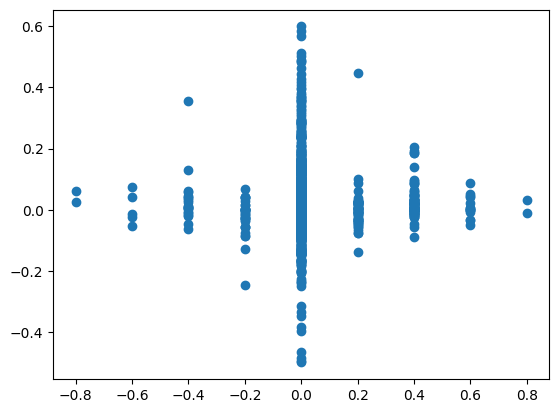

In [19]:
import matplotlib.pyplot as plt

plt.scatter(test['Sentiment'],test['Attribution Score'])

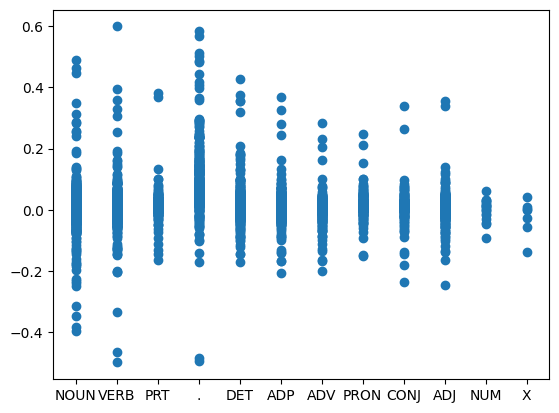

In [20]:
plt.scatter(test['Part of Speech'],test['Attribution Score'])

In [28]:
test[test['Part of Speech']=='NOUN']['Attribution Score']

0        -0.014086
4         0.017428
8         0.025638
12        0.061947
16       -0.010904
            ...   
159658   -0.104641
159661    0.025682
159664   -0.020079
159668    0.049467
159670   -0.025770
Name: Attribution Score, Length: 968, dtype: float64

<ipython-input-22-cfc4b8930c8c>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.plot(test.groupby('Sentiment').agg('mean'))


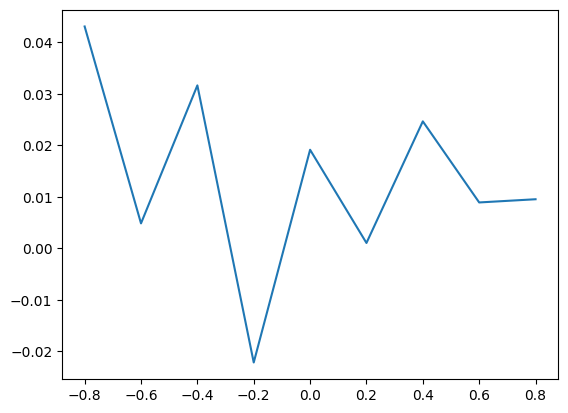